# Лабораторная работа № 5. Часть 3. Гиперпараметры

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [87]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [88]:
train, test = train_test_split(df, test_size=0.2)

feats = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X_train = train[feats]
Y_train = train[['Outcome']]

X_test = test[feats]
Y_test = test[['Outcome']]

Исследование качества модели от глубины

In [89]:
depths = range(1, 26)
f1_scores = []

for depth in depths:
    model = RandomForestClassifier(max_depth=depth, random_state=0)
    model.fit(X_train, Y_train.values[:, 0])
    Y_pred = model.predict(X_test)
    
    f1 = metrics.f1_score(Y_test, Y_pred)
    f1_scores.append(f1)

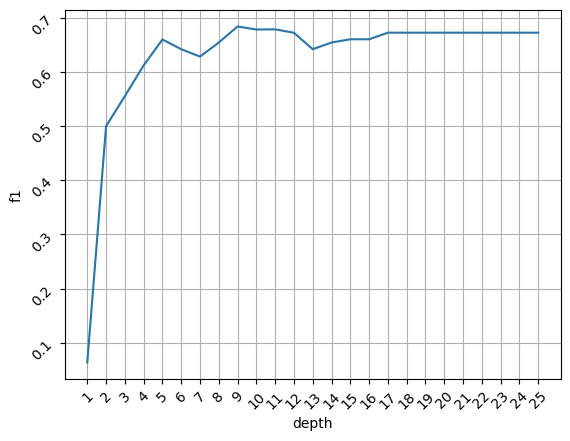

In [90]:
ax = plt.subplot()
ax.plot(depths, f1_scores)
ax.set_xlabel("depth")
ax.set_xticks(depths)
ax.tick_params(labelrotation=45)
ax.grid(visible=True)
ax.set_ylabel("f1")
plt.show()

Исследование качества модели от количества признаков

In [91]:
featnums = range(1, len(feats)+1)
f1_scores = []

for featnum in featnums:
    model = RandomForestClassifier(max_features=featnum, random_state=0)
    model.fit(X_train, Y_train.values[:, 0])
    Y_pred = model.predict(X_test)
    
    f1 = metrics.f1_score(Y_test, Y_pred)
    f1_scores.append(f1)

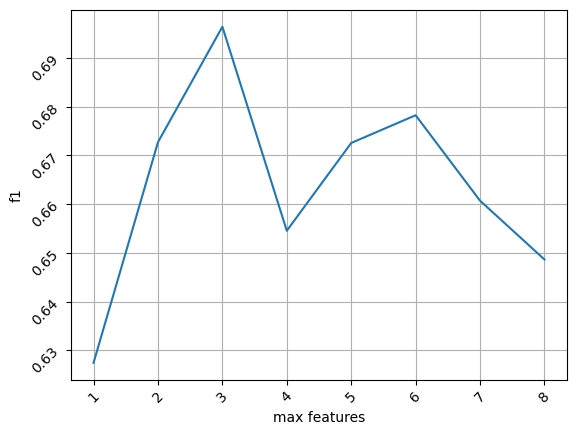

In [92]:
ax = plt.subplot()
ax.plot(featnums, f1_scores)
ax.set_xlabel("max features")
ax.set_xticks(featnums)
ax.tick_params(labelrotation=45)
ax.grid(visible=True)
ax.set_ylabel("f1")
plt.show()

Исследование качества модели от числа деревьев

In [93]:
trees = range(100, 121)
f1_scores = []
fit_times = []

for tree in trees:
    model = RandomForestClassifier(n_estimators=tree, random_state=0)

    start = time.time()
    
    model.fit(X_train, Y_train.values[:, 0])

    fit_times.append(time.time()-start)
    
    Y_pred = model.predict(X_test)
    
    f1 = metrics.f1_score(Y_test, Y_pred)
    f1_scores.append(f1)

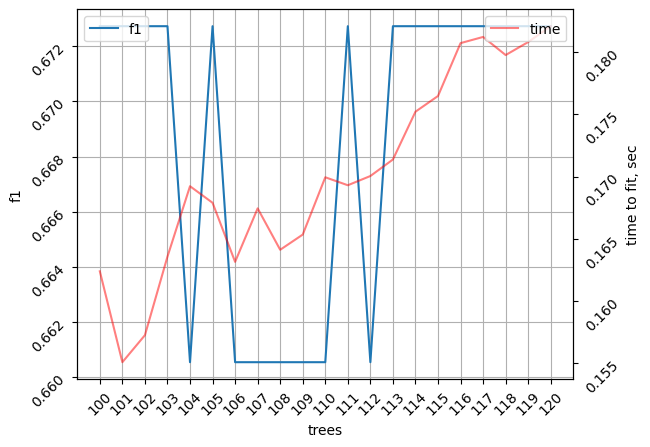

In [94]:
ax = plt.subplot()
ax2 = ax.twinx()

ax.plot(trees, f1_scores, label="f1")
ax2.plot(trees, fit_times, color="r", label="time", alpha=0.5)

ax.set_xlabel("trees")
ax.set_xticks(trees)
ax.tick_params(labelrotation=45)
ax.grid(visible=True)
ax.set_ylabel("f1")
ax2.set_ylabel("time to fit, sec")
ax2.tick_params(labelrotation=45)

ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

Теперь применяем XGBoost, значения подбирались вручную

In [95]:
model_boost = XGBClassifier(n_estimators=8, max_depth=10, reg_alpha=0.5, reg_lambda=0.5, random_state=0)

model_boost.fit(X_train, Y_train)

Y_pred = model_boost.predict(X_test)

In [96]:
metrics.f1_score(Y_test, Y_pred)

0.6071428571428571

Подбираем гиперпараметры через RandomizedSearchCV

In [97]:
model = XGBClassifier(random_state=0)

In [98]:
distributions = dict(n_estimators=range(10, 200), max_depth=range(1, 100), reg_alpha=uniform(0,1), reg_lambda=uniform(0,1), subsample=uniform(0, 1), gamma=uniform(0, 1))
search_model = RandomizedSearchCV(model, distributions, random_state=0)

start = time.time()
search = search_model.fit(X_train, Y_train.values[:, 0])

print(search.best_params_)
print("Time to fit:", time.time() - start)

{'gamma': np.float64(0.5684339488686485), 'max_depth': 1, 'n_estimators': 174, 'reg_alpha': np.float64(0.6176354970758771), 'reg_lambda': np.float64(0.6120957227224214), 'subsample': np.float64(0.6169339968747569)}
Time to fit: 1.5495035648345947


Теперь через Hypropt

In [99]:
space = {
    'max_depth': hp.quniform('max_depth', 1, 100, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'subsample': hp.uniform('subsample', 0, 1),
    'gamma': hp.uniform('gamma', 0, 1)
}

In [100]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'subsample': params['subsample'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'gamma': params['gamma']
    }
    
    model = XGBClassifier(
        eval_metric='logloss',
        **params
    )
    
    scores = cross_val_score(model, X_train, Y_train)
    
    return {'loss': -np.mean(scores), 'status': STATUS_OK}

In [101]:
trials = Trials()
start = time.time()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

print(best)
print("Time to opt:", time.time()- start)

100%|██████████| 50/50 [00:07<00:00,  6.27trial/s, best loss: -0.7752765560442489]
{'gamma': np.float64(0.3640580546759754), 'max_depth': np.float64(1.0), 'n_estimators': np.float64(49.0), 'reg_alpha': np.float64(0.4004779646406229), 'reg_lambda': np.float64(0.13053613560708516), 'subsample': np.float64(0.6166913597434271)}
Time to opt: 7.97947359085083


Видно, что через Hypropt оптимизация заняла куда больше времени, чем через RandomizedSearchCV, но значения параметров получились иные, более оптимальные. В частности, меньше n_estimators уменьшит время fit модели